In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
nside = 4
from mpl_toolkits import mplot3d
from matplotlib import ticker
import healpy as hp
import matplotlib
import copy
from matplotlib import rc
import sys
sys.path.insert(0, '../src/')
from AMC_Density_Evolution import *

import warnings
warnings.filterwarnings("ignore")


###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelpad'] = 8.0
mpl.rcParams['figure.constrained_layout.h_pad'] = .2                
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20#22

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20#22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.8
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 10, 6

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

In [2]:
def theta_cut(arrayVals, Theta, thetaV, eps=0.01):
    if (thetaV - eps) < 0:
        condition1 = Theta < (thetaV + eps)
        condition2 = Theta > np.pi + (thetaV - eps)
        jointC = condition1
    elif (thetaV - eps) > np.pi:
        condition1 = Theta < (thetaV + eps) - np.pi
        condition2 = Theta > (thetaV - eps)
        jointC = Theta > (thetaV - eps)
    else:
        condition1 = Theta < (thetaV + eps)
        condition2 = Theta > (thetaV - eps)
    
        jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
    return arrayVals[jointC]
def phi_cut(arrayVals, Phi, phiV, eps=0.01):
    if (phiV - eps) < -np.pi:
        condition1 = Phi < phiV + eps
        condition2 = Phi > 2 * np.pi + phiV - eps
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    elif (phiV + eps) > np.pi:
        condition1 = Phi < phiV + eps - 2 * np.pi
        condition2 = Phi > phiV - eps
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    else:
        condition1 = Phi < phiV + eps
        condition2 = Phi > phiV - eps
        jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
    return arrayVals[jointC]
@jit(nopython=True)
def ThetaPhi(data):
    Tkf = data[:, 0]
    Pkf = data[:, 1]
    TXf = data[:, 2]
    PXf = data[:, 3]
    rX = data[:, 4]

    Theta = np.zeros(len(rX))
    Phi = np.zeros(len(rX))
    #r_proj = np.max(rX)
    r_proj = 1e10
    for i in range(len(rX)):
        xx = np.array([rX[i] * np.cos(PXf[i]) * np.sin(TXf[i]), rX[i] * np.sin(PXf[i]) * np.sin(TXf[i]), rX[i] * np.cos(TXf[i])])
        vv = np.array([ np.cos(Pkf[i]) * np.sin(Tkf[i]), np.sin(Pkf[i]) * np.sin(Tkf[i]), np.cos(Tkf[i])])
        tproj = -np.sum(xx*vv) + np.sqrt(4*np.sum(xx*vv)**2. - 4 * (rX[i]**2. - r_proj**2.))/2.
        Phi[i] = np.arctan2((vv[1] * tproj + xx[1]), (vv[0] * tproj + xx[0]))
        Theta[i] = np.arccos((vv[2] * tproj + xx[2]) / r_proj)
    return Theta,Phi

def diff_power_curve(arrayVals, ThetaVals, mass, period, binTot=300, eps_theta=0.01, dOM=False):
    thetaL = np.linspace(1e-2, np.pi-1e-2, binTot)
    rate = np.zeros(binTot)
    for i in range(len(thetaL)):
        new_arr = theta_cut(arrayVals, ThetaVals, thetaL[i], eps=eps_theta)
        if (thetaL[i] - eps_theta) < 0.0:
            thetaN = (thetaL[i] + eps_theta) / 2
            epsN = (thetaL[i] + eps_theta) - thetaN
        elif (thetaL[i] + eps_theta) > np.pi:
            thetaN = np.pi - (np.pi - (thetaL[i] - eps_theta)) / 2
            epsN = np.pi - thetaN
        else:
            thetaN = thetaL[i]
            epsN = eps_theta
            
        rate[i] = np.sum(new_arr[:,5]) * mass / ( np.sin(thetaN) * 2 * epsN) / period  # eV / s

    return np.column_stack((thetaL, rate))

def generate_diff_power_plots(fileList,  b_param_list, time, labels, cutN=1.0, ymax=1e40, ymin=1e30, eps_theta=0.01, binTot=300, sve=False, fileTag="DiffPower_", SuppFactor=[1e-6, 1e14, 1, 0], den_avg=[False, True], NS_vel_T=[0.0, 0.0, 0.0], is_axionstar=False, sve_flux=False, loc_leg='upper right'):
    fig, ax = plt.subplots(figsize=(10,6))
    colorL = ["#73AB84", "#79C7C5", "#6B0504", "#94849B", "#FFCAAF"]
    for i,fileN in enumerate(fileList):
        b_param = b_param_list[i]
        if type(is_axionstar) == type(True):
            is_as = is_axionstar
        else:
            is_as = is_axionstar[i]
        file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T[i], is_axionstar=is_as)
        
        # ASSUME COUPLING 1e-14 1/GeV
        # probs = file_use[:,16]
        # probs = (1 - np.exp(-probs)) * np.exp(-probs)
        
        # file_use[:, 5] *= probs / file_use[:,16]
        
        file_use[:, 5] *= SuppFactor[i]
        if den_avg[i]:
            file_use[:, 5] *= np.median(den) 
        else:
            file_use[:, 5] *= den
            # pass
            
        ThetaVals = file_use[:,2]
        mass, period, thetaM = extract_file_params(fileN)
        

        vals = diff_power_curve(file_use, ThetaVals, mass, period, binTot=binTot, eps_theta=eps_theta)
        vals[0,1] = vals[1,1]
        vals[-1,1] = vals[-2,1]

        vals[vals[:,1] <= 0, 1] = 1e10
        plt.plot(vals[:,0], vals[:,1], label=labels[i], c=colorL[i])
        
        if sve_flux:
            np.save("testF_PointSource.npy", vals)
        
    ax.tick_params(direction='in', length=8, width=1, labelsize=18)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=3, width=1, labelsize=12)
    ax.legend(loc=loc_leg,fontsize=14)
    plt.yscale("log")
    plt.xlim([0, np.pi])
    plt.ylim([ymin, ymax])
    plt.xlabel(r'$\theta$ \hspace{.5cm} [rad.]', fontsize=24);
    plt.ylabel(r'$dP / d\theta$ \hspace{.5cm} [eV / s]', fontsize=24);
    print("sve? ", sve)
    if sve:
        plt.savefig("plots_paper/"+fileTag + ".png",dpi=200)
        # np.savetxt("plots_paper/DiffPower.dat", vals)
    return

def extract_file_params(fileN):
    tag1 = fileN.find('rotPulsar_') + len('rotPulsar_')
    tag2 = fileN.find('_B0_')
    period = 2*np.pi / float(fileN[tag1:tag2])
    
    tag1 = fileN.find('_MassAx_') + len('_MassAx_')
    tag2 = fileN.find('_AxG_')
    mass = float(fileN[tag1:tag2])
    
    tag1 = fileN.find('ThetaM_') + len('ThetaM_')
    tag2 = fileN.find('_rotPulsar')
    thetaM = float(fileN[tag1:tag2])
    return mass, period, thetaM

def ShowPlots(fileN, nside, b_param, time, maxF=None, minF=None, den_avg=False, NS_vel_T=0.0, is_axionstar=False, tag="", sve=False):
    file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T, is_axionstar=is_axionstar)
    
    if den_avg:
        file_use[:, 5] *= np.median(den) 
    else:
        file_use[:, 5] *= den

    # ASSUME COUPLING 1e-14 1/GeV
    #probs = file_use[:,16]
    #probs = (1 - np.exp(-probs)) * np.exp(-probs)
    #file_use[:, 5] *= probs / file_use[:,16]
    
    # Theta,Phi = ThetaPhi(file_use)
    Theta = file_use[:,2]
    Phi = file_use[:,3]
    rateT = np.sum(file_use[:, 5])
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)
    ratVs = np.zeros(hp.nside2npix(nside))   
    # Evs = np.zeros(hp.nside2npix(nside))    
    
    MinRate = 1e-12
    
    for i in range(indxs):
        rel_rows = file_use[pixel_indices == i]
        if len(rel_rows) == 0:
            ratVs[i] = MinRate
        else:
            ratVs[i] = np.sum(rel_rows[:, 5]) / rateT 
            if ratVs[i] == 0:
                ratVs[i] = MinRate
    pltRates= np.log10(ratVs / np.max(ratVs))
    cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))    
    hp.mollview(pltRates , title="",xsize=2000, cmap=cmap, cbar=None)
    
    hp.graticule(dmer=360,dpar=360,alpha=0) 
    fontS = 18
    ax = plt.gca()
    im = ax.get_images()[0]
    fig = plt.gcf()
    matplotlib.rcParams.update({'font.size':fontS})
    
    minVal = np.min(pltRates)
    maxVal = np.max(pltRates)
    numPts = 5
    positions= np.linspace(minVal, maxVal, numPts)
    labels = ["{:.1f}".format(minVal)]
    for i in range(numPts-2):
        labels.append("")
    labels.append("{:.1f}".format(maxVal))

    cbarr = fig.colorbar(im, orientation='horizontal',ax=ax, drawedges=False, shrink=0.5, pad=0.05)
    cbarr.set_label(label=r"$\log_{{10}} \hat{F}$", labelpad=-10, fontsize=20)
    cbarr.set_ticks(positions)
    cbarr.set_ticklabels(labels)
    ax.tick_params(labelsize=20)
    
    # fig.axes[1].texts[0].set_fontsize(fontS);
    if sve:
        plt.savefig("plots_paper/SkyMap_Flux_"+tag+".png", dpi=200)
        
def ShowPlots_Width(fileN, nside, b_param, time, maxF=None, minF=None, den_avg=False, NS_vel_T=0.0, is_axionstar=False, tag="", sve=False):
    file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T, is_axionstar=is_axionstar)
    
    if den_avg:
        file_use[:, 5] *= np.median(den) 
    else:
        file_use[:, 5] *= den

    # ASSUME COUPLING 1e-14 1/GeV
    #probs = file_use[:,16]
    #probs = (1 - np.exp(-probs)) * np.exp(-probs)
    #file_use[:, 5] *= probs / file_use[:,16]
    
    # Theta,Phi = ThetaPhi(file_use)
    Theta = file_use[:,2]
    Phi = file_use[:,3]
    rateT = np.sum(file_use[:, 5])
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)
    ratVs = np.zeros(hp.nside2npix(nside))    
    MinRate = 1e-12
     # Evs[i] = np.sum(rel_rows[:,5] * )
    delB = np.zeros(hp.nside2npix(nside))    
    
        
    for i in range(indxs):
        rel_rows = file_use[pixel_indices == i]
        if len(rel_rows) == 0:
            ratVs[i] = MinRate
        else:
            ratVs[i] = np.sum(rel_rows[:, 5]) / rateT 
            if ratVs[i] == 0:
                ratVs[i] = MinRate
                
        vv = np.sqrt(np.sum(file_use[pixel_indices == i,-3:]**2, axis=1))
        delW = file_use[pixel_indices == i,6] - 0.5*(vv) # this is because of me stupidly saving wrong thing
        delB[i] = np.sqrt(np.sum(delW**2 * file_use[pixel_indices == i,5]) / np.sum(file_use[pixel_indices == i,5]) )
        if delB[i] > 0:
            delB[i] = np.log10(delB[i])
        else:
            delB[i] = -10
    cmap = copy.copy(matplotlib.cm.get_cmap("cividis"))    
    if maxF == None:
        maxF = np.max(np.log10(ratVs))
    if minF == None:
        minF = np.min(np.log10(ratVs))
    # print(ratVs)
    # print(np.max(ratVs))
    # delB[delB <= 1e-10] = 1e-10
    minVal = np.min(delB)
    maxVal = np.max(delB)
    print(minVal, maxVal)
    hp.mollview(delB, title="", unit=r"$\log_{{10}} \Delta B $",xsize=2000, cmap=cmap, cbar=None)
    hp.graticule(dmer=360,dpar=360,alpha=0) 
    
    
    fontS = 20
    matplotlib.rcParams.update({'font.size':fontS})
    ax = plt.gca()
    im = ax.get_images()[0]
    fig = plt.gcf()


    numPts = 5
    positions= np.linspace(minVal, maxVal, numPts)
    labels = ["{:.1f}".format(minVal)]
    for i in range(numPts-2):
        labels.append("")
    labels.append("{:.1f}".format(maxVal))

    cbarr = fig.colorbar(im, orientation='horizontal',ax=ax, drawedges=False, shrink=0.5, pad=0.05)
    cbarr.set_label(label=r"$\log_{{10}} \Delta B  $", labelpad=-10, fontsize=20)
    cbarr.set_ticks(positions)
    cbarr.set_ticklabels(labels)
    # cbarr.ax.xaxis.set_tick_params(pad=-10)
    ax.tick_params(labelsize=20) 
    # matplotlib.rcParams.update({'font.size':fontS})
    # fig.axes[1].texts[0].set_fontsize(fontS);

    if sve:
        plt.savefig("plots_paper/SkyMap_Width_"+tag+".png", dpi=200)
        
def time_evol(fileList, thetaL, tList, b_param, NS_vel_T=0.0, is_axionstar=False, tag="", sve=False):
    timeEvo = np.empty(len(thetaL), dtype=object)
    for i in range(len(fileList)):
        fileN = fileList[i]
        time = tlist[i]
        file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T, is_axionstar=is_axionstar)
        file_use[:,5] *= den
    
        
    

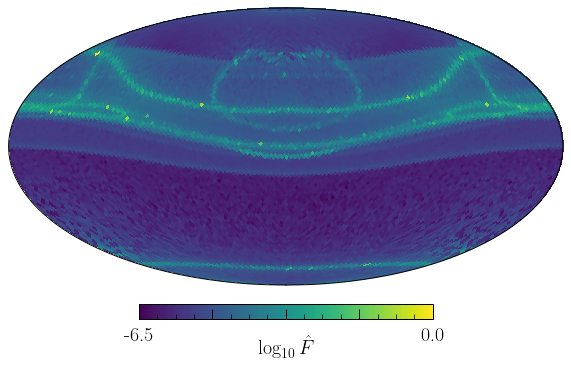

In [52]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

2546721.540723518 15924164538219.422


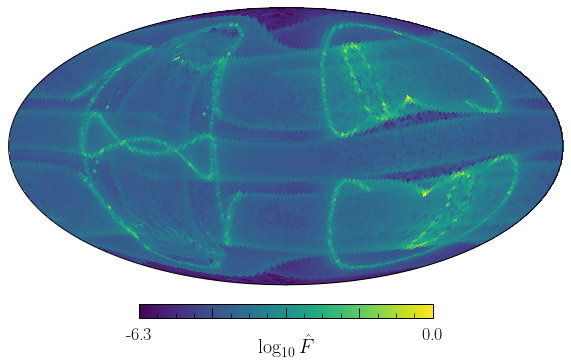

In [133]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 1.57
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-12_Rmc_1.86e9_bx_0_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

67526587.88497008 11415134440352.045


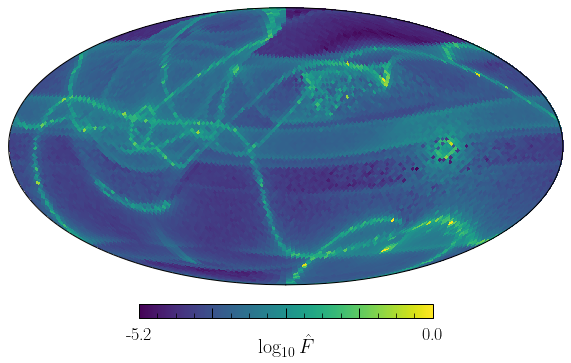

In [134]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.785
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9_bx_0_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131771257.03821234 4415210783317.4795


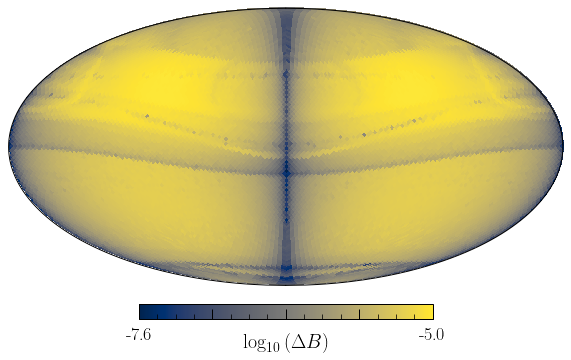

In [135]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots_Width(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

2546721.540723518 15924164538219.422


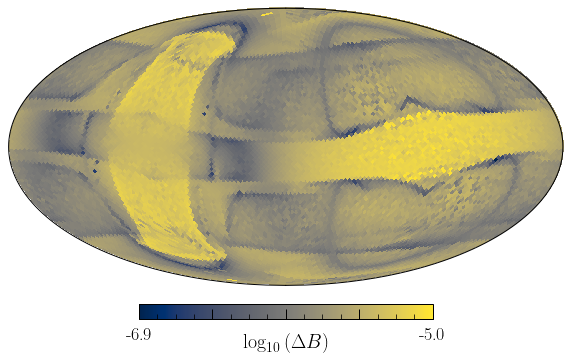

In [136]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 1.57
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-12_Rmc_1.86e9_bx_0_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots_Width(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

67526587.88497008 11415134440352.045


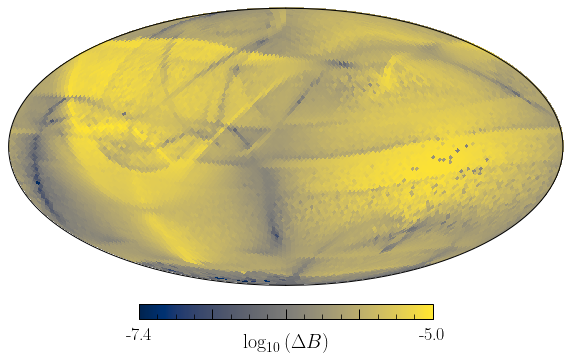

In [139]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.785
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9_bx_0_by_1e8_bz_0_fixed_time_0.0__NFW__"
sve=True
ShowPlots_Width(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

1381.5990839819367 62266798.17110447


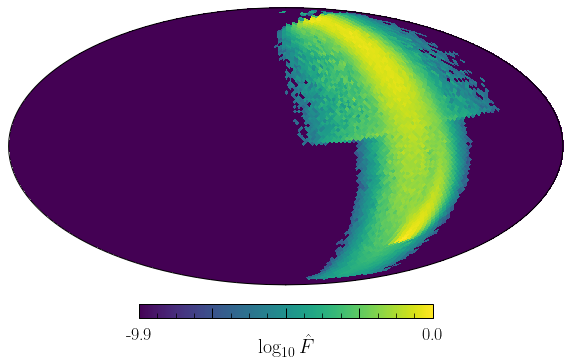

In [147]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 2.0e3, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 1.57
tag = "_Star_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-13_Rmc_3905.0_bx_0_by_2e3_bz_0_fixed_time_0.0_"
sve=True
is_axionstar = True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve, is_axionstar=is_axionstar)

1381.5990839819367 62266798.17110447
-10.0 -5.199377896247955


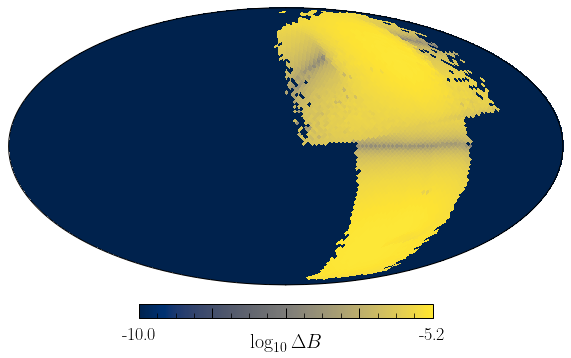

In [146]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([0.0, 2.0e3, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 1.57
tag = "_Star_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-13_Rmc_3905.0_bx_0_by_2e3_bz_0_fixed_time_0.0_"
sve=True
ShowPlots_Width(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131356159.87321097 11442407074465.287


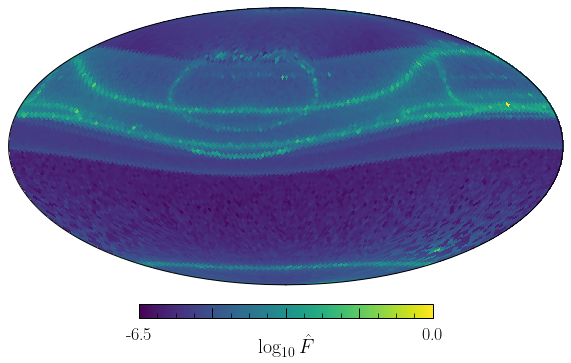

In [158]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.313__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_0.313__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131797269.24726285 7285301345910.217


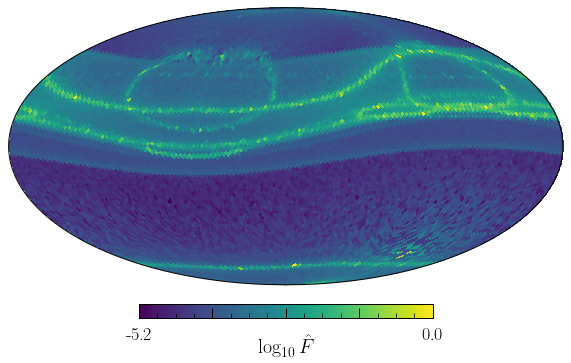

In [159]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.626__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_0.626__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

130921754.3730119 2284882203420.7686


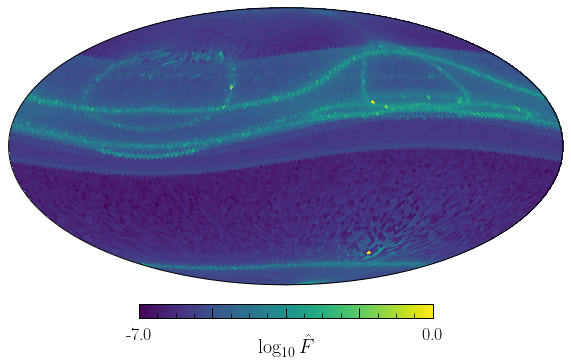

In [160]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.94__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_0.94__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131527543.3549169 2210653806345.5967


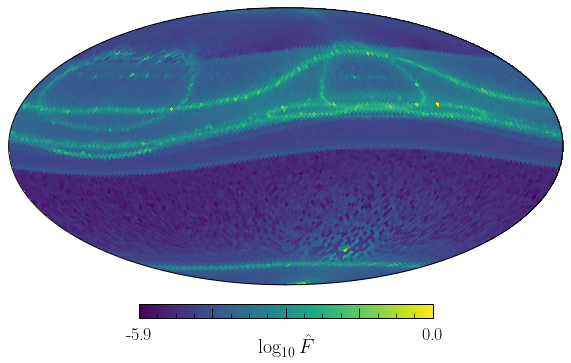

In [161]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_1.253__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_1.253__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131884556.50164966 3413247998599.6016


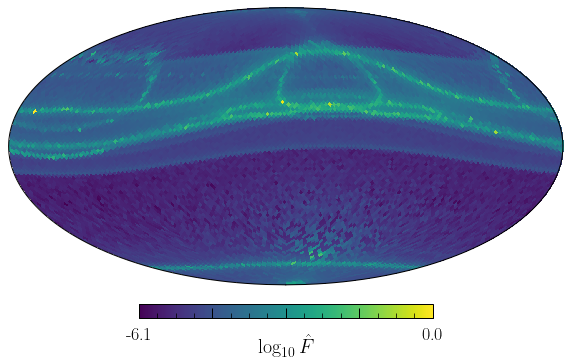

In [162]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_1.566__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_1.566__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

130695074.82440273 3119983558820.983


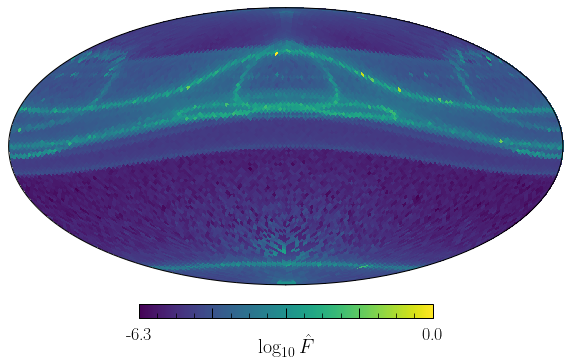

In [163]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_1.88__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_1.88__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

130881353.69602284 16898465310855.18


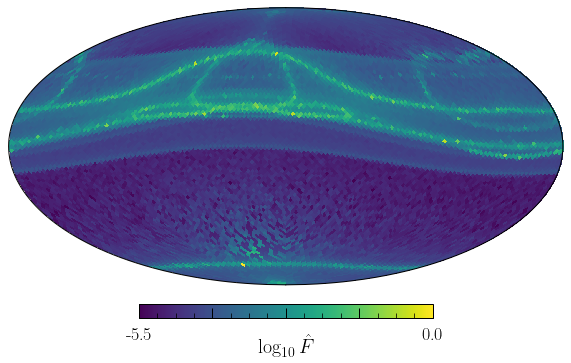

In [164]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_2.193__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_2.193__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

131169583.81887251 5349962799046.0625


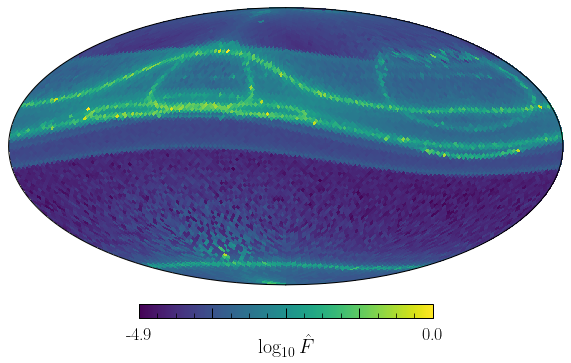

In [165]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_2.506__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_2.506__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

130872178.43431407 9092360971894.02


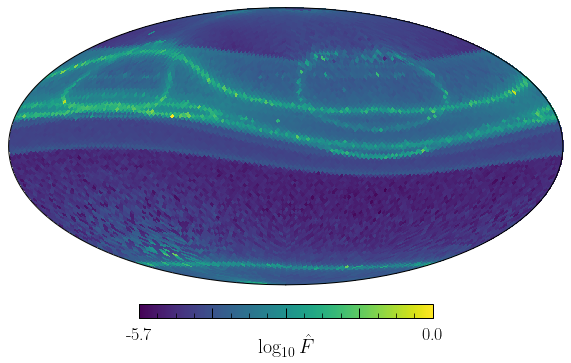

In [166]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_3.133__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_3.133__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

130998661.23116955 2908361927831.1147


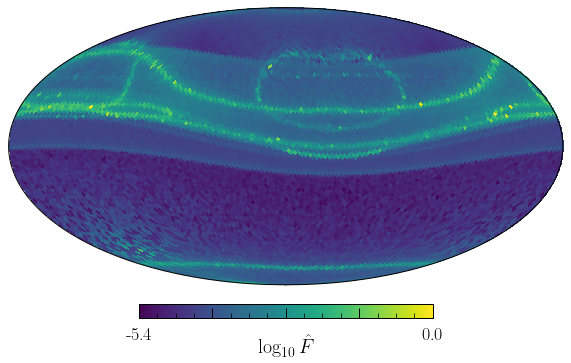

In [167]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_3.44__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
tag = "_Minicluster_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9_bx_1e8_by_1e8_bz_0_fixed_time_3.44__NFW__"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

sve?  True


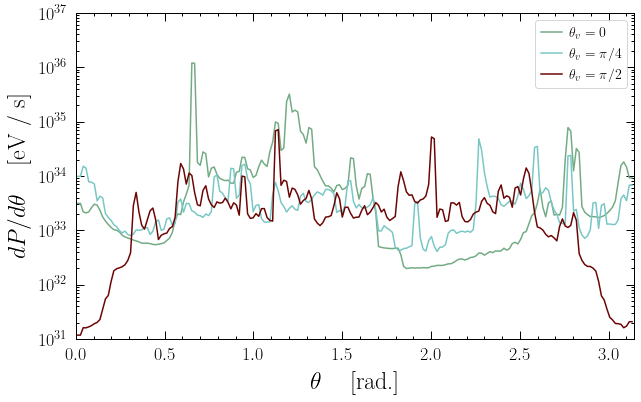

In [16]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3]
labels = [r"$\theta_v = 0$", r"$\theta_v = \pi / 4$", r"$\theta_v = \pi/2$"]
SuppFactor = [1, 1, 1]
fileTag = "Diff_power_AMC_NS_Mag_0.00033_Mmc_1.0e-12_Rmc_1.86e9_fixed_time_0.0_"
b_param = [np.asarray([1.0e8, 0.0, 0.0]), np.asarray([1.0e8 / np.sqrt(2), 1.0e8 / np.sqrt(2), 0.0]), np.asarray([0.0, 1.0e8, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
NS_vel_T = [0.0, 0.785, 1.57]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.015, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e37, ymin=1e31, sve_flux=sve_flux)

sve?  True


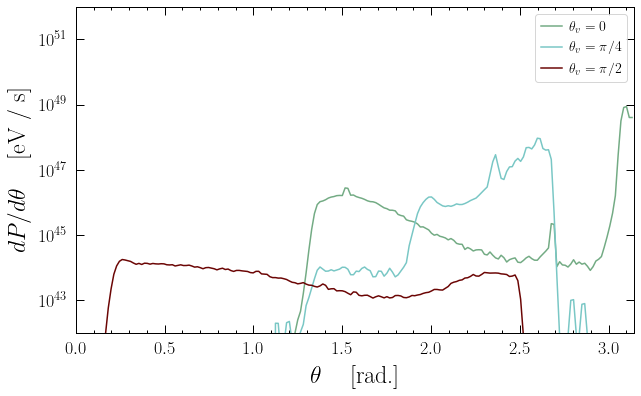

In [19]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_1.57_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3]
labels = [r"$\theta_v = 0$", r"$\theta_v = \pi / 4$", r"$\theta_v = \pi/2$"]
SuppFactor = [1, 1, 1]
fileTag = "Diff_power_Star_NS_Mag_0.00033_Mmc_1.0e-13_Rmc_3905.0_fixed_time_0.0_"
b_param = [np.asarray([1.0e3, 0.0, 0.0]), np.asarray([1.0e3 / np.sqrt(2), 1.0e3 / np.sqrt(2), 0.0]), np.asarray([0.0, 1.0e3, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
is_axionstar = True
NS_vel_T = [0.0, 0.785, 1.57]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.015, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e52, ymin=1e42, sve_flux=sve_flux, is_axionstar=is_axionstar)

sve?  True


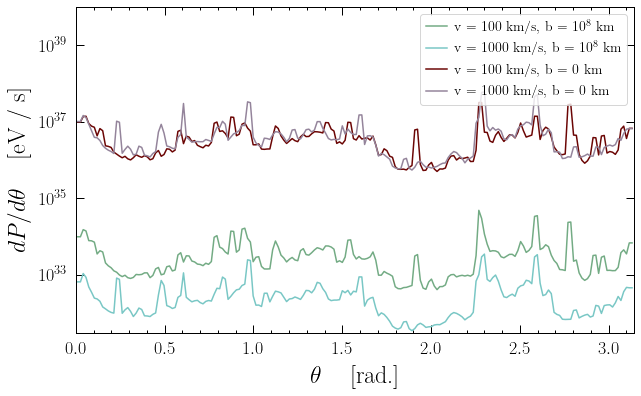

In [31]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00334_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN4 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00334_NS_Theta_0.785_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"

# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3, fileN4]
labels = [r"v = 100 km/s, b = $10^8$ km", r"v = 1000 km/s, b = $10^8$ km", r"v = 100 km/s, b = 0 km", r"v = 1000 km/s, b = 0 km"]
SuppFactor = [1, 1, 1, 1]
fileTag = "Diff_Flux_AMC_Comparison_Change_Vel_and_Impact_"
b_param = [np.asarray([1.0e8 / np.sqrt(2), 1.0e8 / np.sqrt(2), 0.0]), np.asarray([1.0e8 / np.sqrt(2), 1.0e8 / np.sqrt(2), 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0])]
den_avg = [False, False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
NS_vel_T = [0.785, 0.785, 0.785, 0.785]
is_axionstar = [False, False, False, False]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.015, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e40, ymin=3e31, sve_flux=sve_flux)

sve?  True


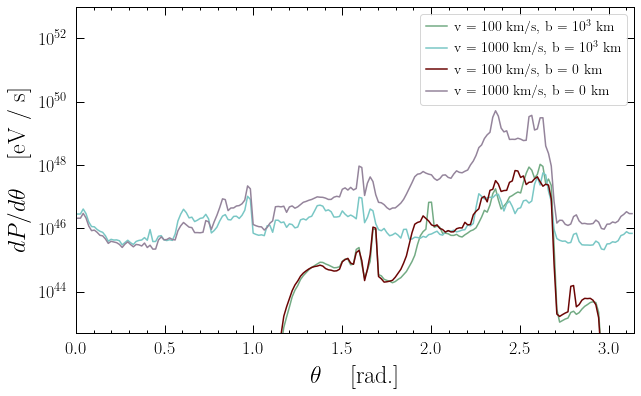

In [32]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00334_NS_Theta_0.785_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.785_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN4 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00334_NS_Theta_0.785_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"

# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3, fileN4]
labels = [r"v = 100 km/s, b = $10^3$ km", r"v = 1000 km/s, b = $10^3$ km", r"v = 100 km/s, b = 0 km", r"v = 1000 km/s, b = 0 km"]
SuppFactor = [1, 1, 1, 1]
fileTag = "Diff_Flux_AS_Comparison_Change_Vel_and_Impact_"
b_param = [np.asarray([1.0e3 / np.sqrt(2), 1.0e3 / np.sqrt(2), 0.0]), np.asarray([1.0e3 / np.sqrt(2), 1.0e3 / np.sqrt(2), 0.0]), np.asarray([0.0, 0.0, 0.0]), np.asarray([0.0, 0.0, 0.0])]
den_avg = [False, False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
NS_vel_T = [0.785, 0.785, 0.785, 0.785]
is_axionstar = [True, True, True, True]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.015, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e53, ymin=5e42, sve_flux=sve_flux)

sve?  True


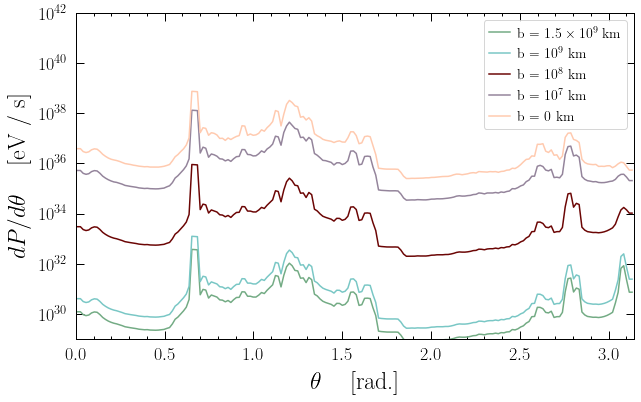

In [51]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN4 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN5 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3, fileN4, fileN5]
labels = [r"b = $1.5 \times 10^9$ km", r"b = $10^9$ km", r"b = $10^8$ km", r"b = $10^7$ km",  r"b = $0$ km"]
SuppFactor = [1, 1, 1, 1, 1]
fileTag = "Diff_Flux_AMC_Varying_B_"
b_param = [np.asarray([1.5e9, 0.0, 0.0]), np.asarray([1.0e9, 0.0, 0.0]), np.asarray([1.0e8, 0.0, 0.0]), np.asarray([1.0e7, 0.0, 0.0]), np.asarray([0.0, 0.0, 0.0])]
den_avg = [False, False, False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
NS_vel_T = [0.0, 0.0, 0.0, 0.0, 0.0]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.02, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymin=1e29, ymax=1e42, sve_flux=sve_flux)

sve?  True


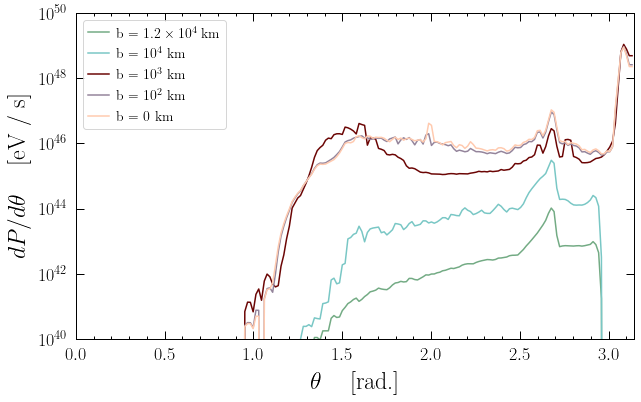

In [47]:
fileN1 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN2 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN3 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN4 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
fileN5 = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-13_Rmc_3905.0__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3, fileN4, fileN5]
labels = [r"b = $1.2 \times 10^4$ km", r"b = $10^4$ km", r"b = $10^3$ km", r"b = $10^2$ km",  r"b = $0$ km"]
SuppFactor = [1, 1, 1, 1, 1]
fileTag = "Diff_Flux_AS_Varying_B_"
b_param = [np.asarray([1.2e4, 0.0, 0.0]), np.asarray([1.0e4, 0.0, 0.0]), np.asarray([1.0e3, 0.0, 0.0]), np.asarray([1.0e2, 0.0, 0.0]), np.asarray([0.0, 0.0, 0.0])]
den_avg = [False, False, False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
sve=True
NS_vel_T = [0.0, 0.0, 0.0, 0.0, 0.0]
is_axionstar = True
loc_leg = 'upper left'
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.02, binTot=200, sve=sve, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymin=1e40, ymax=1e50, sve_flux=sve_flux, loc_leg=loc_leg)